In [4]:
#!pip install control
#!pip install slycot

In [1]:
# importa os modulo necessários 

import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import control as ct
from slycot import *
plt.style.use('_mpl-gallery')


# 1 Modelagem pelo módulo Sympy

In [2]:
# Definindo as variáveis simbólicas

# Constantes
M, m1, m2, m3, l1, l2,J1, J2, g, t, f0, f1, f2 = sym.symbols('M m1 m2 m3 l1 l2 J1 J2 g t  f0 f1 f2')

# Variáveis
phi1, phi2, x,u ,theta1, theta2 = sym.symbols(r'phi1 phi2 x u theta1 theta2', cls=sym.Function) # funções para se trabalhar em cima


In [3]:
# Definindo as derivadas no tempo 

x = x(t)  # Posição x do carro 
u = u(t)  # Variável de controle
phi1 = phi1(t) # Ângulo do pêndulo inferior
phi2 = phi2(t) # Ângulo do pêndulo superior
theta1 = theta1(t) # Ângulo do linearizado 
theta2 = theta2(t) # Ângulo do linearizado

x_d = sym.diff(x, t) # Velocidade do carro
phi1_d = sym.diff(phi1, t) # Velocidade angular do pendulo inferior
phi2_d = sym.diff(phi2, t) # Velocidade angular do pendulo superior

x_dd = sym.diff(x_d, t) # Aceleração do carro
phi1_dd = sym.diff(phi1_d, t) # Aceleração angular do pendulo inferior
phi2_dd = sym.diff(phi2_d, t) # Aceleração angular do pendulo superior

# Simplificação
dpdp2=phi2_d*phi2_d
dpdp1=phi1_d*phi1_d
dxdx=x_d*x_d

In [4]:
# Equação de Lagrange: L = T-U

# Energia cinética e potencial carro:
Kc = 1/2 * M *dxdx
Pc = 0

# Energia cinética e potencial do pendulo inferior:
Kp_1 = 1/2 * m1  *dxdx + m1* x_d*l1*phi1_d*sym.cos(phi1)+ 1/2 *dpdp1*(m1*l1*l1+J1)
Pp_1 = m1*g*l1*sym.cos(phi1)

# Energia cinética e potencial do pendulo superior:
Kp_2 = 1/2 *m2*(dxdx + 2*x_d*(2*l1*phi1_d*sym.cos(phi1)+l2*phi2_d*sym.cos(phi2)))\
+1/2 *m2*(4*l1*l1*dpdp1+l2*l2*dpdp2+4*l1*l2*phi1_d*phi2_d*sym.cos(phi1-phi2))+1/2 *J2*dpdp2
Pp_2 = m2*g*(2*l1*sym.cos(phi1)+l2*sym.cos(phi2))

# Energia cinética e potencial total:
P_total = Pc + Pp_1 + Pp_2
K_total = Kc + Kp_1 + Kp_2 
L = K_total - P_total
L

0.5*J2*Derivative(phi2(t), t)**2 + 0.5*M*Derivative(x(t), t)**2 - g*l1*m1*cos(phi1(t)) - g*m2*(2*l1*cos(phi1(t)) + l2*cos(phi2(t))) + l1*m1*cos(phi1(t))*Derivative(phi1(t), t)*Derivative(x(t), t) + 0.5*m1*Derivative(x(t), t)**2 + 0.5*m2*(2*(2*l1*cos(phi1(t))*Derivative(phi1(t), t) + l2*cos(phi2(t))*Derivative(phi2(t), t))*Derivative(x(t), t) + Derivative(x(t), t)**2) + 0.5*m2*(4*l1**2*Derivative(phi1(t), t)**2 + 4*l1*l2*cos(phi1(t) - phi2(t))*Derivative(phi1(t), t)*Derivative(phi2(t), t) + l2**2*Derivative(phi2(t), t)**2) + 0.5*(J1 + l1**2*m1)*Derivative(phi1(t), t)**2

In [5]:
# Equaçoes das variaveis generalizadas:

# Coordenada generalizada X:
eqnx = sym.diff(sym.diff(L,x_d),t)-sym.diff(L,x)-u+f0*x_d

# Coordenada generalizada phi1:
eqn_phi1 = sym.diff(sym.diff(L,phi1_d),t)-sym.diff(L,phi1)+(f1+f2)*phi1_d -f2*phi2_d

# Coordenada generalizada phi2:
eqn_phi2 = sym.diff(sym.diff(L,phi2_d),t)-sym.diff(L,phi2)-f2*phi1_d + f2*phi2_d



# Solução das equaçoes das variáveis generalizadas
# Solução para X
sol_xdd = sym.solve(eqnx, x_dd)[0]
# Solução para phi1
sol_phi1dd = sym.solve(eqn_phi1, phi1_dd)[0]
# Solução para phi1
sol_phi2dd = sym.solve(eqn_phi2, phi2_dd)[0]

In [6]:
# Matriz dos estados
q = sym.Matrix([x,theta1,theta2])

# Matriz das derivadas de estados
q_d = sym.Matrix([(x_d,phi1_d,phi2_d)])

# Matriz das 2º derivadas de estados
q_dd = sym.Matrix([(x_dd,phi1_dd,phi2_dd)])

# Matriz estados total
q_ef = sym.Matrix([q,q_dd.transpose()])


# Ponto de equilibrio - Linearização
ponto_eq = {x:0,x_d:0,x_dd:0,phi1:0,phi2:0,phi1_d:0,phi2_d:0,phi2_dd:0,phi1_dd:0,sym.cos(phi1):1,\
            sym.cos(phi2):1,sym.cos(phi1-phi2):1,sym.sin(phi1):theta1,sym.sin(phi2):theta2}


In [7]:
# Matriz H de Massas do sistema:
H = sym.Matrix((sym.diff(eqnx,q_dd),sym.diff(eqn_phi1,q_dd),sym.diff(eqn_phi2,q_dd))).subs(ponto_eq)

# Matriz H inversa
H_inv = H.inv()
H

Matrix([
[1.0*M + 1.0*m1 + 1.0*m2,                    l1*m1 + 2.0*l1*m2,             1.0*l2*m2],
[      l1*m1 + 2.0*l1*m2, 1.0*J1 + 1.0*l1**2*m1 + 4.0*l1**2*m2,          2.0*l1*l2*m2],
[              1.0*l2*m2,                         2.0*l1*l2*m2, 1.0*J2 + 1.0*l2**2*m2]])

In [8]:
N = sym.Matrix((sym.diff(eqnx,q_d),sym.diff(eqn_phi1,q_d),sym.diff(eqn_phi2,q_d))).subs(ponto_eq)
N

Matrix([
[f0,       0,   0],
[ 0, f1 + f2, -f2],
[ 0,     -f2,  f2]])

In [9]:
W = sym.Matrix([0,-g*l1*sym.sin(phi1)*(m1+2*m2),-g*m2*l2*sym.sin(phi2)]).subs(ponto_eq)
W

Matrix([
[                          0],
[-g*l1*(m1 + 2*m2)*theta1(t)],
[         -g*l2*m2*theta2(t)]])

In [10]:
# Matriz de entradas
V = sym.Matrix([u,0,0])
V

Matrix([
[u(t)],
[   0],
[   0]])

In [11]:
# Multiplicação matricial

C = N*q_d.transpose() + W
S = (H_inv*C).subs(ponto_eq)
S

Matrix([
[                                  -g*l1*(m1 + 2*m2)*(-1.0*J2*l1*m1 - 2.0*J2*l1*m2 - 1.0*l1*l2**2*m1*m2)*theta1(t)/(1.0*J1*J2*M + 1.0*J1*J2*m1 + 1.0*J1*J2*m2 + 1.0*J1*M*l2**2*m2 + 1.0*J1*l2**2*m1*m2 + 1.0*J2*M*l1**2*m1 + 4.0*J2*M*l1**2*m2 + 1.0*J2*l1**2*m1*m2 + 1.0*M*l1**2*l2**2*m1*m2) - g*l2*m2*(-1.0*J1*l2*m2 + 1.0*l1**2*l2*m1*m2)*theta2(t)/(1.0*J1*J2*M + 1.0*J1*J2*m1 + 1.0*J1*J2*m2 + 1.0*J1*M*l2**2*m2 + 1.0*J1*l2**2*m1*m2 + 1.0*J2*M*l1**2*m1 + 4.0*J2*M*l1**2*m2 + 1.0*J2*l1**2*m1*m2 + 1.0*M*l1**2*l2**2*m1*m2)],
[                 -g*l1*(m1 + 2*m2)*(1.0*J2*M + 1.0*J2*m1 + 1.0*J2*m2 + 1.0*M*l2**2*m2 + 1.0*l2**2*m1*m2)*theta1(t)/(1.0*J1*J2*M + 1.0*J1*J2*m1 + 1.0*J1*J2*m2 + 1.0*J1*M*l2**2*m2 + 1.0*J1*l2**2*m1*m2 + 1.0*J2*M*l1**2*m1 + 4.0*J2*M*l1**2*m2 + 1.0*J2*l1**2*m1*m2 + 1.0*M*l1**2*l2**2*m1*m2) - g*l2*m2*(-2.0*M*l1*l2*m2 - 1.0*l1*l2*m1*m2)*theta2(t)/(1.0*J1*J2*M + 1.0*J1*J2*m1 + 1.0*J1*J2*m2 + 1.0*J1*M*l2**2*m2 + 1.0*J1*l2**2*m1*m2 + 1.0*J2*M*l1**2*m1 + 4.0*J2*M*l1**2*m2 + 1.0

In [12]:
B_0 = sym.Matrix([q_dd.transpose(),H_inv*V])
B_0

Matrix([
[                                                                                                                                                                                                                                                  Derivative(x(t), (t, 2))],
[                                                                                                                                                                                                                                               Derivative(phi1(t), (t, 2))],
[                                                                                                                                                                                                                                               Derivative(phi2(t), (t, 2))],
[(1.0*J1*J2 + 1.0*J1*l2**2*m2 + 1.0*J2*l1**2*m1 + 4.0*J2*l1**2*m2 + 1.0*l1**2*l2**2*m1*m2)*u(t)/(1.0*J1*J2*M + 1.0*J1*J2*m1 + 1.0*J1*J2*m2 + 1.0*J1*M*l2**2*m2 + 1.0*J1*l2**2*m1*m2 +

In [13]:
# Solução Final 
f = sym.Matrix([q_dd.transpose(),S])
f

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          Derivative(x(t), (t, 2))],
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [14]:
f_s = f.jacobian(q_ef)
f_s

Matrix([
[0,                                                                                                                                                                                                                                                                   0,                                                                                                                                                                                                                                                                           0, 1, 0, 0],
[0,                                                                                                                                                                                                                                                                   0,                                                                                                                                                                                       

In [17]:
# Obtendo as matrizes numericas de estados A 

# Valor dos parâmetros do sistema:
valor_param_dGisele = {M:1,m1:1,m2:1,J1:0.00083,J2:0.00083,\
               l1:0.05,l2:0.05,g:9.81,f0:0.01,f1:0.007,f2:0.007}
valor_param_Yadav = {M:0.8,m1:0.5,m2:0.3,J1:0.006,J2:0.006,\
               l1:0.15,l2:0.15,g:9.81,f0:0.01,f1:0.007,f2:0.007}
# Matriz A
A_s = f_s.subs(valor_param_dGisele)
A = np.matrix(A_s).astype(np.float64)
A

matrix([[   0.        ,    0.        ,    0.        ,    1.        ,
            0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        ,    0.        ,
            1.        ,    0.        ],
        [   0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    1.        ],
        [   0.        ,   14.73466591,   -1.64374696,    0.        ,
            0.        ,    0.        ],
        [   0.        , -442.33526109,  147.64194295,    0.        ,
            0.        ,    0.        ],
        [   0.        ,  442.92582886, -344.30101097,    0.        ,
            0.        ,    0.        ]])

In [18]:
# Matriz B
b_i = B_0.jacobian([u])
B_s = b_i.subs(valor_param_dGisele)
B = np.matrix(B_s).astype(np.float64)
#b_i
B

matrix([[  0.        ],
        [  0.        ],
        [  0.        ],
        [  0.77814879],
        [-10.01336453],
        [  3.35116609]])

In [19]:
# Matriz C
C = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]])

# Matriz D
D = np.zeros((6,1))

In [27]:
# Discretização
sys = ct.ss(A,B,C,D)
Ts = 0.02

sys_discreto = ct.c2d(sys,Ts, method='zoh')

Ad = sys_discreto.A
Bd = sys_discreto.B
Cd = sys_discreto.C

# 2 Modelagem pelo módulo Numpy

# 3 Estabilidade

In [39]:
# Criando o sistema em State Space
sys = ct.ss(A,B,C,D)
print(sys_discreto)

<StateSpace>: sys[9]$sampled
Inputs (1): ['u[0]']
Outputs (6): ['y[0]', 'y[1]', 'y[2]', 'y[3]', 'y[4]', 'y[5]']
States (6): ['x[0]', 'x[1]', 'x[2]', 'x[3]', 'x[4]', 'x[5]']

A = [[ 1.00000000e+00  7.33720376e-04 -8.10478923e-05  1.00000000e-02
       2.44974831e-06 -2.71677320e-07]
     [ 0.00000000e+00  9.77991778e-01  7.33381421e-03  0.00000000e+00
       9.92649467e-03  2.45103624e-05]
     [ 0.00000000e+00  2.20014426e-02  9.82861431e-01  0.00000000e+00
       7.35310872e-05  9.94276955e-03]
     [ 0.00000000e+00  1.46142716e-01 -1.59822453e-02  1.00000000e+00
       7.33720376e-04 -8.10478923e-05]
     [ 0.00000000e+00 -4.37998234e+00  1.45712802e+00  0.00000000e+00
       9.77991778e-01  7.33381421e-03]
     [ 0.00000000e+00  4.37138405e+00 -3.41244934e+00  0.00000000e+00
       2.20014426e-02  9.82861431e-01]]

B = [[ 3.88437813e-05]
     [-4.98620711e-04]
     [ 1.65235254e-04]
     [ 7.75604726e-03]
     [-9.93154714e-02]
     [ 3.25835785e-02]]

C = [[1. 0. 0. 0. 0. 0.]
     

In [25]:
# MAtriz de controlabilidade
Co = ct.ctrb(Ad,Bd)
rank = np.linalg.matrix_rank(Co)    
print('Rank da Matriz de controlabilidade:',rank)
Co_s =sym.Matrix(Co)
Co_s

Rank da Matriz de controlabilidade: 6


Matrix([
[ 0.00015461664492623, 0.000452033656651963,  0.00071645918204992,  0.000933491336334818,  0.00109817295710691,  0.00121538863239847],
[-0.00197011172384793, -0.00553212359474356, -0.00804959873799101,  -0.00910380877368056, -0.00861881713066506, -0.00687064805116759],
[0.000633336475970001,  0.00147435138511289,   0.0011612452909778, -0.000698053859047386, -0.00403392603441934,  -0.0083113737904056],
[  0.0153610732874229,   0.0142004411604037,   0.0121197912379173,   0.00954177680184425,  0.00696876687439127,  0.00486264529777104],
[  -0.193781505067866,   -0.156730798283816,   -0.091445033989739,   -0.0133353003870602,   0.0594661566891303,    0.110646744612144],
[  0.0596801179582243,   0.0181659252272288,   -0.052852372305818,    -0.132500706949474,   -0.196524482530867,   -0.223698951702695]])

In [29]:
# MAtriz de observabilidade
Ob = ct.obsv(Ad,Cd)
rank_obsr = np.linalg.matrix_rank(Ob)    
print('Rank da Matriz de observabilidade:',rank_obsr)
Ob_s = sym.Matrix(Ob)
Ob_s

Rank da Matriz de observabilidade: 6


Matrix([
[1.0,                   0,                     0,    0,                    0,                     0],
[  0,                 1.0,                     0,    0,                    0,                     0],
[  0,                   0,                   1.0,    0,                    0,                     0],
[  0,                   0,                     0,  1.0,                    0,                     0],
[  0,                   0,                     0,    0,                  1.0,                     0],
[  0,                   0,                     0,    0,                    0,                   1.0],
[1.0, 0.00289901940164222, -0.000310651541463286, 0.02,  1.94541203499027e-5,  -2.11906816729805e-6],
[  0,   0.913258545705653,    0.0287610662615021,    0,   0.0194171388778984,   0.00019377871510358],
[  0,  0.0862831987845063,     0.932355893703291,    0,  0.00058133614531074,    0.0195458079447271],
[  0,   0.285149484707365,    -0.029273097858509,  1.0,  0.00289901940164

In [30]:
# Polos do sistema
polos = ct.poles(sys_discreto)
zeros_s = ct.zeros(sys_discreto)
print('Os polos do sistema são: ', polos \
    , 'Os zeros do sistema são: ',zeros_s)

Os polos do sistema são:  [1.        +0.j         1.        +0.j         0.8720847 +0.48935496j
 0.8720847 -0.48935496j 0.97352974+0.22856038j 0.97352974-0.22856038j] Os zeros do sistema são:  []


(array([1.        +0.j        , 1.        +0.j        ,
        0.8720847 +0.48935496j, 0.8720847 -0.48935496j,
        0.97352974+0.22856038j, 0.97352974-0.22856038j]),
 array([], dtype=float64))

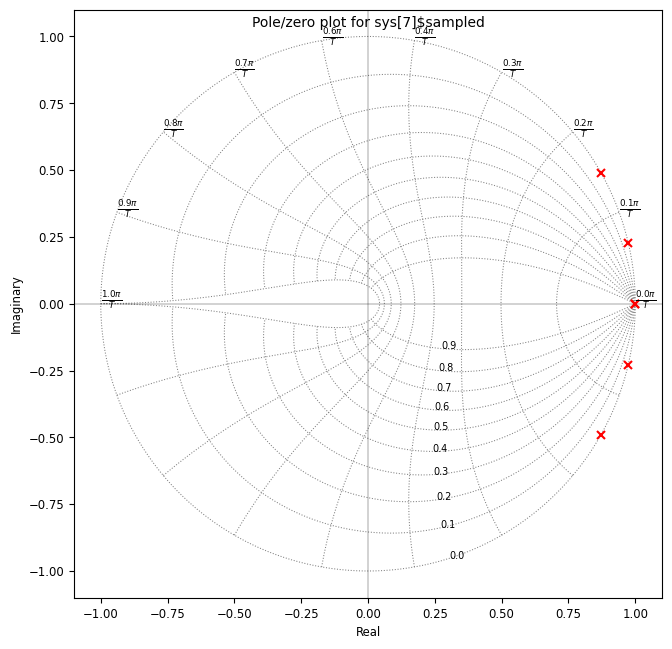

In [31]:
# Pólos do sistema
plt.figure(figsize=(6, 6)) 
ct.pzmap(sys_discreto ,plot=True,grid=True,marker_color='r')

In [44]:
# Plotar resposta inicial do sistema

x0 = np.array([[0.0],[0.01],[0.0],[0],[0],[0]])
tp = np.arange(0, 5, Ts) 
#t,y = ct.initial_response(sys, tp,x0) # Resposta Inicial
t,y = ct.initial_response(sys_discreto, tp,x0) # Resposta Inicial
r,d = ct.step_response(sys,tp,x0) # Resposta ao degrau

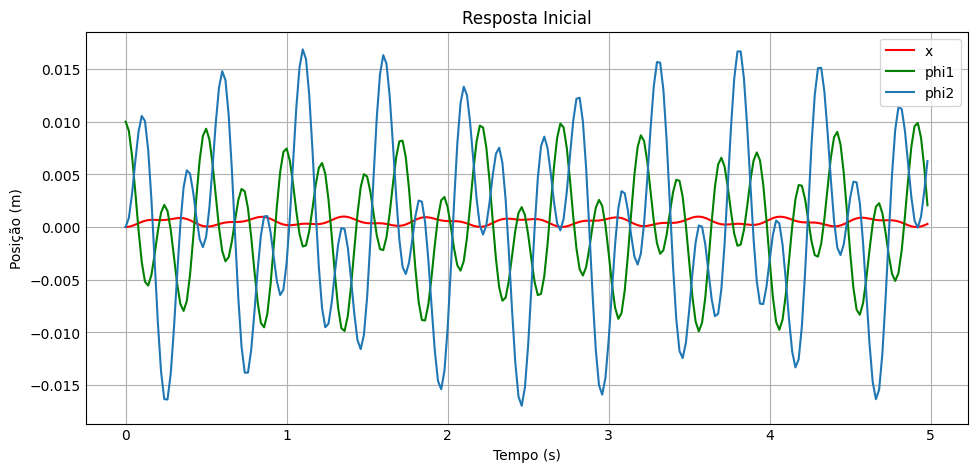

In [45]:

altura = 4
largura = 9
subplots = plt.subplots(1, 1, figsize=(largura, altura))
subplots[1].plot(t,y[0], '-r',label='x')
subplots[1].plot(t,y[1], '-g',label='phi1')
subplots[1].plot(t,y[2], label='phi2')
subplots[1].set_title('Resposta Inicial')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posição (m)')
subplots[1].grid(True)
subplots[1].legend()
plt.show()



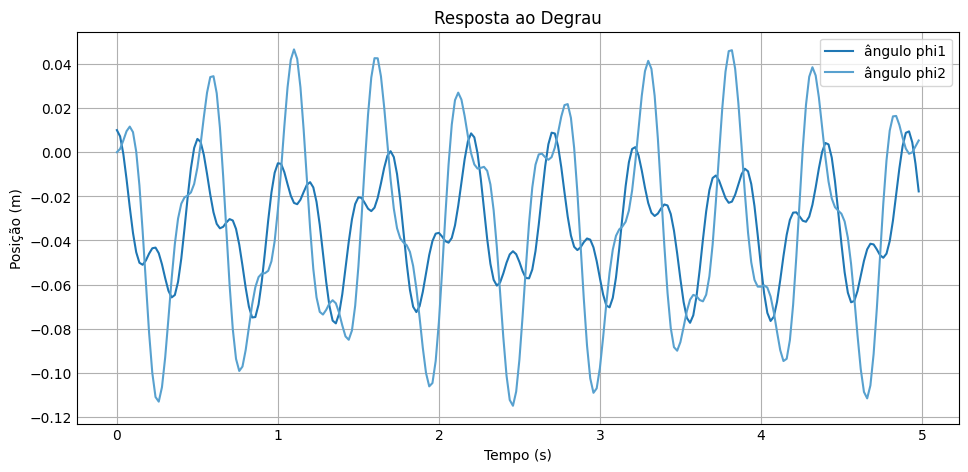

In [46]:
altura = 4
largura = 9
subplots = plt.subplots(1, 1, figsize=(largura, altura))
#subplots[1].plot(t,d[0][0], label='x')
subplots[1].plot(t,d[1][0], label='ângulo phi1')
subplots[1].plot(t,d[2][0], label='ângulo phi2')
subplots[1].set_title('Resposta ao Degrau')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posição (m)')
subplots[1].grid(True)
subplots[1].legend()
plt.show()